# Break down per Country

Here I will look at how many times a song is on the toplist for each country and in total.

I will also look at time on the toplist.

## Import stuff

In [82]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.preprocessing import StandardScaler
import sklearn.metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

from matplotlib import pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline

## Load data

In [83]:
data = pd.read_csv('./data_top10c_more_lyrics.csv')
data.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,Country,Region,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,gb,eu,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.879
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.756
2,2,78,49766,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-24,2017,12,24,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.756


## Fix a little bit with the data

#### Get dummies for song per country

In [84]:
country_dum = pd.get_dummies(data['Country'])
country_dum.head(3)

,au,ca,de,fr,gb,it,nl,us
0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0


#### Add the country dummies to the big df

In [85]:
data_c = pd.concat([data, country_dum], axis=1)
data_c.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,...,Tempo,Valence,au,ca,de,fr,gb,it,nl,us
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,...,172.656,0.879,0,0,0,0,1,0,0,0
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,...,105.003,0.756,0,0,0,0,0,1,0,0
2,2,78,49766,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-24,2017,12,24,...,105.003,0.756,0,0,0,0,0,1,0,0


#### Group by song ID, summing up each column

In [86]:
data_c_groupbyID = data_c.groupby('ID').sum()
data_c_groupbyID.head(3)

,Unnamed: 0,Position,Streams,Year,Month,Day,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence,au,ca,de,fr,gb,it,nl,us
ID,,,,,,,,,,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,485336363,85033,62948380,1716467,4972,13379,111.48100,533.577,0.000000,851.0,102939.513,445.924,228.0,108.0,55.0,20.0,211.0,53.0,108.0,68.0
007d7JT41sSc1HqWTs4uw7,624441,563,233403,6051,8,30,0.00912,2.286,0.000000,0.0,368.748,0.972,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
00BuKLSAFkaEkaVAgIMbeA,310234,121,209865,2017,2,6,0.00587,0.832,0.000789,0.0,122.021,0.713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Drop columns that I do not need for this

In [87]:
dataID_c = data_c_groupbyID.drop(['Unnamed: 0', 'Position', 'Streams', 'Year', 'Month', 'Day', 'Acousticness',
                        'Energy', 'Instrumentalness', 'Mode', 'Tempo', 'Valence'], axis=1)
dataID_c.head(3)

,au,ca,de,fr,gb,it,nl,us
ID,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,228.0,108.0,55.0,20.0,211.0,53.0,108.0,68.0
007d7JT41sSc1HqWTs4uw7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
00BuKLSAFkaEkaVAgIMbeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


We can now see how many times a song appear on the top list for each country.
Reminder, maximum time possible on the top list is 365 days.

We could have done it per country with this code:<BR />
*data_c.groupby('ID')['au'].sum().reset_index()*

**Check that we do not have any missing data**

In [88]:
dataID_c.isnull().sum()

au    0
ca    0
de    0
fr    0
gb    0
it    0
nl    0
us    0
dtype: int64

#### Make a column for total and average times on toplist for each song

In [89]:
a = dataID_c.T.sum().T

In [90]:
b = dataID_c.T.mean().T

In [91]:
dataID_c['total_toplist'] = a

In [92]:
dataID_c['average_toplist'] = b 

In [93]:
dataID_c.head(3)

,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
ID,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,228.0,108.0,55.0,20.0,211.0,53.0,108.0,68.0,851.0,106.375
007d7JT41sSc1HqWTs4uw7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.375
00BuKLSAFkaEkaVAgIMbeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.125


In [94]:
# Maximum total times on toplist
365*8

2920

#### Make a new column for ID so that I can merge on ID later

In [95]:
dataID_c['ID'] = dataID_c.index
dataID_c.head(3)

,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist,ID
ID,,,,,,,,,,,
000xQL6tZNLJzIrtIgxqSl,228.0,108.0,55.0,20.0,211.0,53.0,108.0,68.0,851.0,106.375,000xQL6tZNLJzIrtIgxqSl
007d7JT41sSc1HqWTs4uw7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,3.0,0.375,007d7JT41sSc1HqWTs4uw7
00BuKLSAFkaEkaVAgIMbeA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.125,00BuKLSAFkaEkaVAgIMbeA


#### Drop rows in the original df data that are duplicates and keep only one row for each song (based on ID)

In [96]:
data_per_song = data.drop_duplicates(subset=['ID'], keep='first')
data_per_song.head(3)

,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,Country,Region,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
0,0,177,40381,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,2017-10-05,2017,10,5,gb,eu,"hey, hey bye bye bye, bye bye bye bye i'm doi...",0.0408,0.928,0.00104,0.0,172.656,0.8790
1,1,151,24132,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2017-12-23,2017,12,23,it,eu,merry christmas and happy holidays merry chris...,0.1030,0.939,0.00000,1.0,105.003,0.7560
43,43,147,43037,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI,2017-12-24,2017,12,24,fr,eu,NaN,0.9140,0.227,0.16300,1.0,81.887,0.0498


#### Drop all columns in the df data that are not Track Name, Artist or ID

In [97]:
data_per_song = data_per_song.drop(['Unnamed: 0', 'Position', 'Streams', 'Date', 'Year', 'Month', 'Day', 'Country',
                                   'Region', 'Lyrics', 'Acousticness', 'Energy', 'Instrumentalness', 'Mode',
                                   'Tempo', 'Valence'], axis=1)
data_per_song.head(3)

,Track Name,Artist,ID
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR
43,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI


### On the top list in how many of the 8 countries?

#### Combine the 2 data frames on ID column

In [98]:
big_df_song = data_per_song.merge(dataID_c, how='inner', on='ID')
big_df_song.head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
0,Bye Bye Bye,*NSYNC,4r8lRYnoOGdEi6YyI5OC1o,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.125
1,"Merry Christmas, Happy Holidays",*NSYNC,15coTBAzEN1bOeipoNDZAR,2.0,4.0,24.0,0.0,1.0,3.0,4.0,4.0,42.0,5.250
2,Douce Nuit,-M-,4EOJWkvkVDpkZrhC8iTDsI,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.125


How to interpret the data frame:<BR />
*For example the song Bye Bye Bye by NSYNC only appear on toplists in total 1 time. That is is Great Britain. So on average between the coutries it's on the toplist 0.125 times. We can also say that the song is on the toplist 1/(365x8) of all possible time.*

### What song is appearing the most on a toplist in total?

How long is it up in total and per country?

In [99]:
big_df_song.sort_values(by=['total_toplist'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
1990,Shape of You,Ed Sheeran,7qiZfU4dY1lWllzX7mPBI3,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,2856.0,357.000
3239,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,362.0,360.0,218.0,183.0,360.0,276.0,361.0,361.0,2481.0,310.125
1902,One Dance,Drake,1xznGGDReH1oQq0xzbwXa3,360.0,356.0,267.0,330.0,359.0,237.0,237.0,330.0,2476.0,309.500


In [100]:
2856/(365*8)

0.9780821917808219

How to interpret the output:<BR />
*The song that appear on the toplist the most in total is Shape of You by Ed Sheeran. It is on the toplist 97.8% of all time it can be on a toplist. On average between the 8 countries it is on the toplist for 357 days of the year. In this case the song is as popular in every country.*

### What song is the most popular in what country?

**Australia**

In [102]:
big_df_song.sort_values(by=['au'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
1292,Redbone,Childish Gambino,3kxfsdsCpFgN412fpnW85Y,362.0,361.0,72.0,83.0,353.0,15.0,78.0,362.0,1686.0,210.750
3239,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,362.0,360.0,218.0,183.0,360.0,276.0,361.0,361.0,2481.0,310.125
7395,Mr. Brightside,The Killers,7oK9VyNzrYvRFo7nQEYkWN,362.0,6.0,1.0,0.0,362.0,0.0,0.0,23.0,754.0,94.250


**Canada**

In [103]:
big_df_song.sort_values(by=['ca'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
7715,goosebumps,Travis Scott,6gBFPUFcJLzWGx4lenP6h2,321.0,362.0,45.0,2.0,234.0,175.0,3.0,362.0,1504.0,188.000
1292,Redbone,Childish Gambino,3kxfsdsCpFgN412fpnW85Y,362.0,361.0,72.0,83.0,353.0,15.0,78.0,362.0,1686.0,210.750
5304,Bad and Boujee (feat. Lil Uzi Vert),Migos,4Km5HrUvYTaSUfiSGPJeQR,278.0,360.0,149.0,169.0,210.0,80.0,122.0,361.0,1729.0,216.125


**Deuchland / Germany**

In [104]:
big_df_song.sort_values(by=['de'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
880,Ohne mein Team,Bonez MC,05Mp2UJulSttxQ4E6hQPH3,0.0,0.0,362.0,0.0,0.0,0.0,0.0,0.0,362.0,45.25
5087,Solo Dance,Martin Jensen,6HUnnBwYZqcED1eQztxMBN,320.0,243.0,357.0,246.0,336.0,283.0,331.0,128.0,2244.0,280.50
1990,Shape of You,Ed Sheeran,7qiZfU4dY1lWllzX7mPBI3,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,2856.0,357.00


*Comment: The topsong was only poluplar in Germany*

**France**

In [105]:
big_df_song.sort_values(by=['fr'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
6028,Onizuka,PNL,4GCIYE1x1TWJCChPkpy9by,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,360.0,45.000
6016,Bené,PNL,00X2yv2vrtritPt2CZnUTZ,0.0,0.0,0.0,360.0,0.0,0.0,0.0,0.0,360.0,45.000
5641,Mauvaise graine,Nekfeu,4kKJ5CjwCtksszPMntho4N,0.0,0.0,0.0,357.0,0.0,0.0,0.0,0.0,357.0,44.625


*Comment: The topsong was only poluplar in France*

**Great Britain**

In [106]:
big_df_song.sort_values(by=['gb'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
7395,Mr. Brightside,The Killers,7oK9VyNzrYvRFo7nQEYkWN,362.0,6.0,1.0,0.0,362.0,0.0,0.0,23.0,754.0,94.250
3239,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,362.0,360.0,218.0,183.0,360.0,276.0,361.0,361.0,2481.0,310.125
1902,One Dance,Drake,1xznGGDReH1oQq0xzbwXa3,360.0,356.0,267.0,330.0,359.0,237.0,237.0,330.0,2476.0,309.500


**Italy**

In [108]:
big_df_song.sort_values(by=['it'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
6887,Visiera A Becco,Sfera Ebbasta,0nB7VgMGBTeOIO6LXwOvEJ,0.0,0.0,0.0,0.0,0.0,362.0,0.0,0.0,362.0,45.25
4923,Veleno 6,Madman,7GfXjqXD9aBvDoBdZ7EwPH,0.0,0.0,0.0,0.0,0.0,362.0,0.0,0.0,362.0,45.25
3095,Chic,Izi,7jUJ2RmT4PFHHq4goMWqm3,0.0,0.0,0.0,0.0,0.0,362.0,0.0,0.0,362.0,45.25


*Comment: The topsong was only poluplar in France*

**The Netherlands**

In [110]:
big_df_song.sort_values(by=['nl'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
3239,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,362.0,360.0,218.0,183.0,360.0,276.0,361.0,361.0,2481.0,310.125
1990,Shape of You,Ed Sheeran,7qiZfU4dY1lWllzX7mPBI3,357.0,357.0,357.0,357.0,357.0,357.0,357.0,357.0,2856.0,357.000
1965,Castle on the Hill,Ed Sheeran,6PCUP3dWmTjcTtXY02oFdT,357.0,310.0,245.0,133.0,357.0,230.0,335.0,233.0,2200.0,275.000


**US**

In [111]:
big_df_song.sort_values(by=['us'], ascending=False).head(3)

,Track Name,Artist,ID,au,ca,de,fr,gb,it,nl,us,total_toplist,average_toplist
7715,goosebumps,Travis Scott,6gBFPUFcJLzWGx4lenP6h2,321.0,362.0,45.0,2.0,234.0,175.0,3.0,362.0,1504.0,188.00
3745,iSpy (feat. Lil Yachty),KYLE,2EEeOnHehOozLq4aS0n6SL,275.0,358.0,124.0,40.0,245.0,90.0,124.0,362.0,1618.0,202.25
1292,Redbone,Childish Gambino,3kxfsdsCpFgN412fpnW85Y,362.0,361.0,72.0,83.0,353.0,15.0,78.0,362.0,1686.0,210.75


### Graf, nar pa topplista (per land) - kanske gar att kombinera senare

#### Make Date column into date time

In [129]:
data['Date'].head(3)

0    2017-10-05
1    2017-12-23
2    2017-12-24
Name: Date, dtype: object

In [128]:
data['Date'].dtype

dtype('O')

In [131]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

In [132]:
data['Date'].dtype

dtype('<M8[ns]')

#### Look at each country individually

In [133]:
data['Country'].unique()

array(['gb', 'it', 'us', 'de', 'ca', 'nl', 'au', 'fr'], dtype=object)

In [151]:
# filter by country and make 8 new data frames
gb_data = data[data['Country'] == 'gb']
it_data = data[data['Country'] == 'it']
us_data = data[data['Country'] == 'us']
de_data = data[data['Country'] == 'de']
ca_data = data[data['Country'] == 'ca']
nl_data = data[data['Country'] == 'nl']
au_data = data[data['Country'] == 'au']
fr_data = data[data['Country'] == 'fr']

**Great Britain -> James Arthur - Say You Won't Let Go**

In [135]:
gb_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


,Unnamed: 0,Position,Streams,Track Name,Artist,ID,Date,Year,Month,Day,Country,Region,Lyrics,Acousticness,Energy,Instrumentalness,Mode,Tempo,Valence
240110,240110,3,194633,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,2017-01-01,2017,1,1,gb,eu,"i met you in the dark, you lit me up you made ...",0.695,0.557,0.0,1.0,85.043,0.494
240111,240111,4,240217,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,2017-01-02,2017,1,2,gb,eu,"i met you in the dark, you lit me up you made ...",0.695,0.557,0.0,1.0,85.043,0.494
240112,240112,4,260138,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,2017-01-03,2017,1,3,gb,eu,"i met you in the dark, you lit me up you made ...",0.695,0.557,0.0,1.0,85.043,0.494
240113,240113,4,265281,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,2017-01-04,2017,1,4,gb,eu,"i met you in the dark, you lit me up you made ...",0.695,0.557,0.0,1.0,85.043,0.494
240114,240114,4,253597,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,2017-01-05,2017,1,5,gb,eu,"i met you in the dark, you lit me up you made ...",0.695,0.557,0.0,1.0,85.043,0.494
240115,240115,7,247924,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,2017-01-06,2017,1,6,gb,eu,"i met you in the dark, you lit me up you made ...",0.695,0.557,0.0,1.0,85.043,0.494
240116,240116,8,266458,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,2017-01-07,2017,1,7,gb,eu,"i met you in the dark, you lit me up you made ...",0.695,0.557,0.0,1.0,85.043,0.494
240117,240117,6,261305,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,2017-01-08,2017,1,8,gb,eu,"i met you in the dark, you lit me up you made ...",0.695,0.557,0.0,1.0,85.043,0.494
240118,240118,6,263746,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,2017-01-09,2017,1,9,gb,eu,"i met you in the dark, you lit me up you made ...",0.695,0.557,0.0,1.0,85.043,0.494
240119,240119,6,272773,Say You Won't Let Go,James Arthur,5uCax9HTNlzGybIStD3vDh,2017-01-10,2017,1,10,gb,eu,"i met you in the dark, you lit me up you made ...",0.695,0.557,0.0,1.0,85.043,0.494


In [136]:
gb_position = gb_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Position']

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [137]:
gb_date = gb_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Date']

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


In [144]:
gb_song = pd.concat([gb_position, gb_date], axis=1)

In [147]:
gb_song = gb_song.set_index('Date')
gb_song.head(3)

,Position
Date,
2017-01-01,3
2017-01-02,4
2017-01-03,4


**Italy  -> James Arthur - Say You Won't Let Go**

In [153]:
it_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']

it_position = it_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Position']
it_date = it_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Date']

it_song = pd.concat([it_position, it_date], axis=1)

it_song = it_song.set_index('Date')

it_song.head(3)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Position
Date,
2017-01-01,17
2017-01-02,15
2017-01-03,12


**US  -> James Arthur - Say You Won't Let Go**

In [170]:
us_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']

us_position = us_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Position']
us_date = us_data[data['ID'] == '5uCax9HTNlzGybIStD3vDh']['Date']

us_song = pd.concat([us_position, us_date], axis=1)

us_song = us_song.set_index('Date')

us_song.head(3)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()
/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


,Position
Date,
2017-01-01,37
2017-01-02,21
2017-01-03,19


#### Combine in one plot

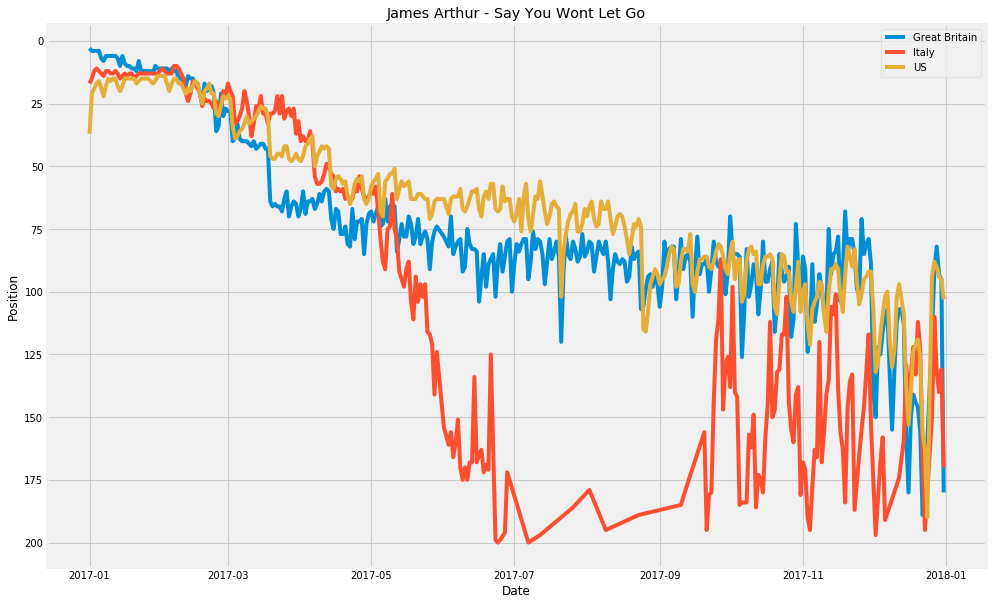

In [174]:
fig, ax = plt.subplots(figsize=(15,10))

ax.plot(gb_song, label='Great Britain')
ax.plot(it_song, label='Italy')
ax.plot(us_song, label='US')

plt.gca().invert_yaxis() # invert values on Y-axis

plt.xlabel('Date');
plt.ylabel('Position');
plt.title('James Arthur - Say You Wont Let Go');
plt.legend();